<a href="https://colab.research.google.com/github/hallpaz/3dsystems23/blob/main/lab8_point_clouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

## Lab Class #8 - Point Clouds

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

# Part 2 - From Meshes to Point Clouds

A polygonal mesh is a representation that is naturally related to a point cloud. If we ignore the topology data, that is, the description of how the mesh vertices are connected to each other, we are left with a trivial point cloud. 

We are going to visualize a more sophisticated point cloud by sampling points over a mesh. Pytorch3D has a function called `sample_points_from_meshes` that converts "a batch of meshes to a batch of pointclouds by uniformly sampling points on the surface of the mesh with probability proportional to the face area" ([docs](https://pytorch3d.readthedocs.io/en/latest/_modules/pytorch3d/ops/sample_points_from_meshes.html)). 


1.1 Load a mesh in PyTorch3D and use the function `sample_points_from_meshes` to create a point cloud from your mesh. Visualize it using the Plotly backend.


1.2 Try different resolutions of point clouds by varying how many points you sample from the mesh; also, experiment different meshes.

In [ ]:
# code here

# Part 2 - From Depth Images to Point Clouds

Our next goal is to load data from an RGB-D image and build a Point Cloud from it.


2.1 Download some examples of depth images (for example, the NYU Dataset suggested in the challenge of assignment 6 has a lot of these images).


2.2 Read some examples. Use the depth channel to build a point cloud in space. Normalize it so that it is centered at the origin and contained in $[-1, 1]^3$. Use the data in the RGB channels to build `TextureVertex` object.


2.3 Visualize the textured point clouds using the Plotly viewer in PyTorch3D.

In [ ]:
# code here

# Part 3 - Modeling your own Point Clouds

3.1 In computer graphics, we can describe media objects like surfaces with a parametric of implicit representation. If you (hypothetically) needed to create a procedural Point Cloud of an object, which one you would choose? Why?


3.2 Write a code to create point clouds for 2 different shapes using the kind of representation you chose above. Add a texture to them, and visualize them using the Plotly backend.

In [ ]:
# code here

# Part 4 - Point Cloud Analysis using the Point Net Model


4.1 Download a dataset of 3D models with at least 4 different labeled classes. For instance, you could use [ShapeNet](https://shapenet.org/), [Objaverse](https://objaverse.allenai.org/), [ModelNet10](https://3dvision.princeton.edu/projects/2014/3DShapeNets/) or the [NYU Depth Dataset v2](). Create a Dataset class that inherints from PyTorch library's Dataset to load your data so that you have point clouds and labels. Split your dataset in train data and test data.


4.2 Train a Point Net model to classify your dataset based on the objects point clouds.


4.3 Evaluate the performance of your classifier.

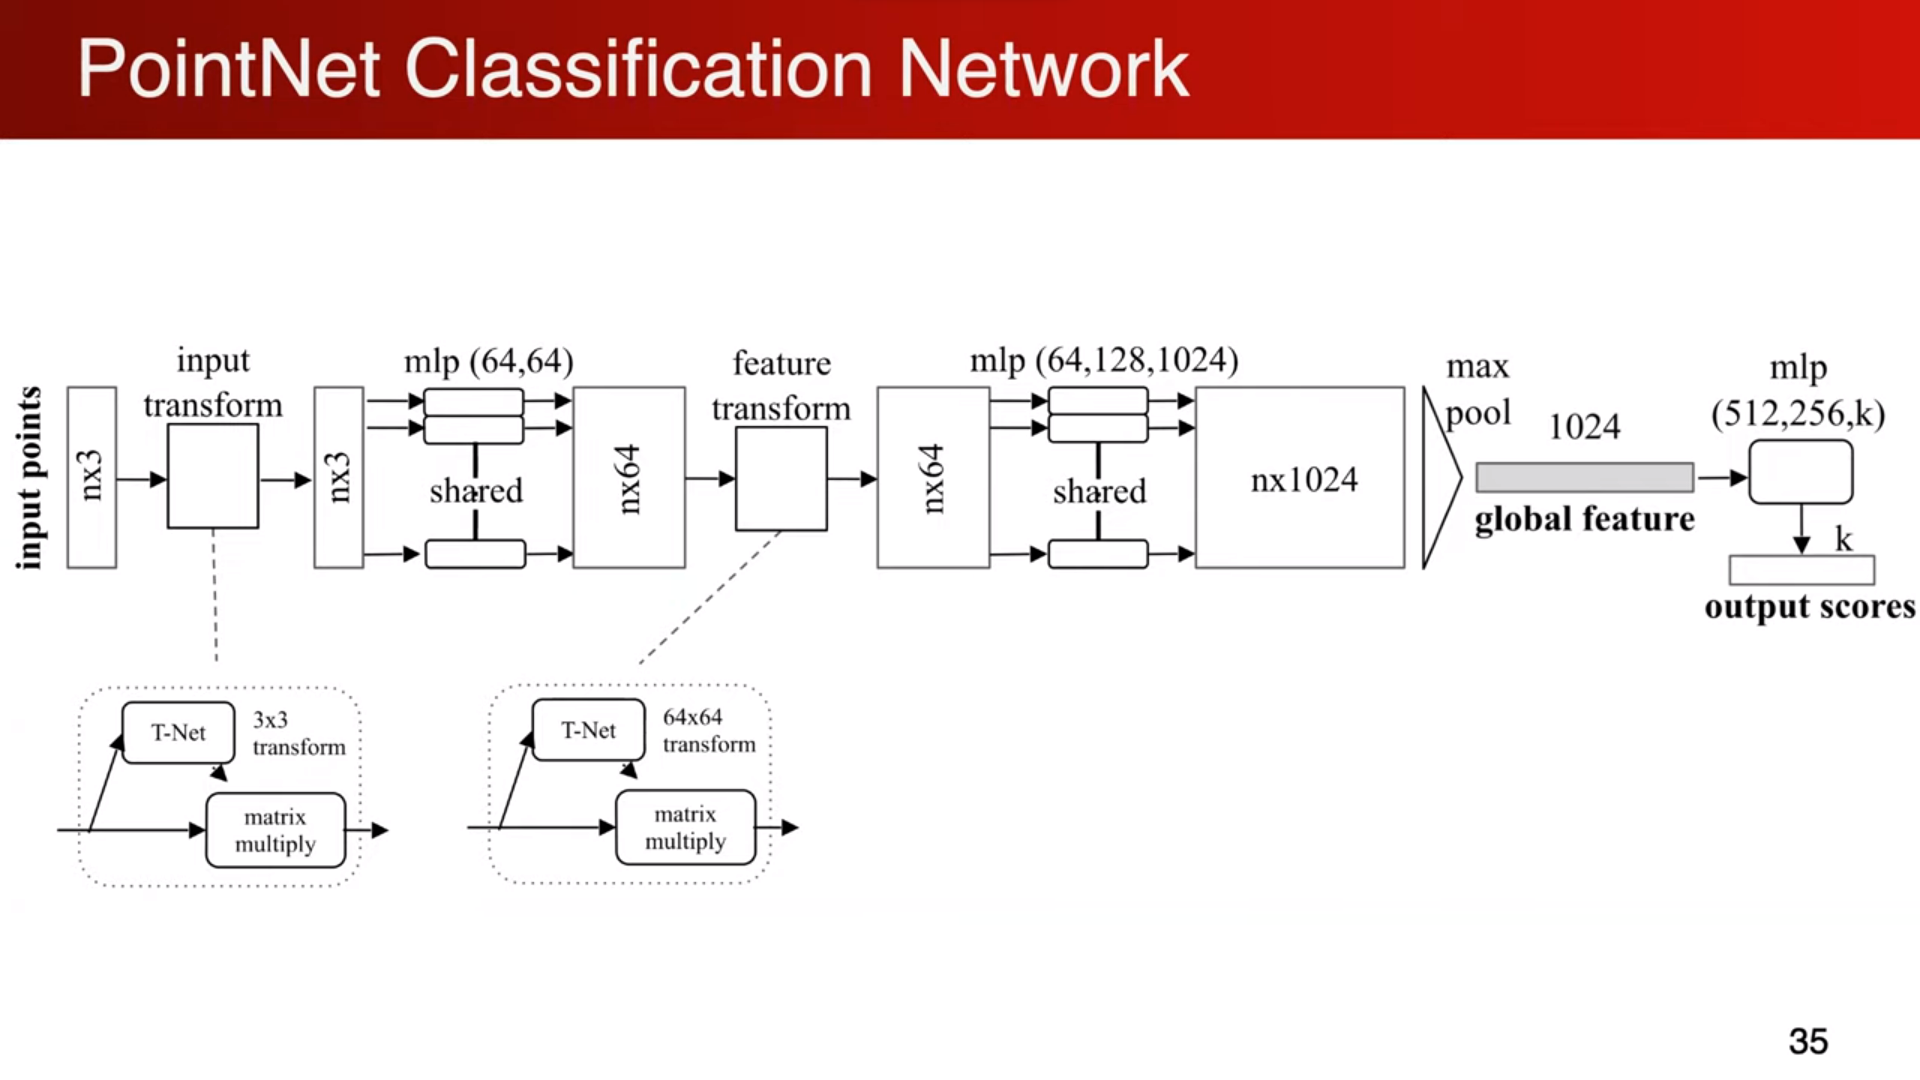

In [5]:
# model source code: https://datascienceub.medium.com/pointnet-implementation-explained-visually-c7e300139698
import torch.nn as nn
import torch.nn.functional as F
  
class TransformationNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 64, 1)
        self.conv_2 = nn.Conv1d(64, 128, 1)
        self.conv_3 = nn.Conv1d(128, 256, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(128)
        self.bn_3 = nn.BatchNorm1d(256)
        self.bn_4 = nn.BatchNorm1d(256)
        self.bn_5 = nn.BatchNorm1d(128)

        self.fc_1 = nn.Linear(256, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_3 = nn.Linear(128, self.output_dim*self.output_dim)

    def forward(self, x):
        num_points = x.shape[1]
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 256)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x


class PointNet(nn.Module):

    def __init__(self, num_classes, point_dimension=3):
        super().__init__()
        self.input_transform = TransformationNet(input_dim=point_dimension, 
                                                 output_dim=point_dimension)
        self.feature_transform = TransformationNet(input_dim=64, output_dim=64)
        
        self.conv_1 = nn.Conv1d(point_dimension, 64, 1)
        self.conv_2 = nn.Conv1d(64, 64, 1)
        self.conv_3 = nn.Conv1d(64, 64, 1)
        self.conv_4 = nn.Conv1d(64, 128, 1)
        self.conv_5 = nn.Conv1d(128, 256, 1)

        self.bn_1 = nn.BatchNorm1d(64)
        self.bn_2 = nn.BatchNorm1d(64)
        self.bn_3 = nn.BatchNorm1d(64)
        self.bn_4 = nn.BatchNorm1d(128)
        self.bn_5 = nn.BatchNorm1d(256)
        self.bn_6 = nn.BatchNorm1d(128)
        self.bn_7 = nn.BatchNorm1d(64)

        self.fc_1 = nn.Linear(256, 128)
        self.fc_2 = nn.Linear(128, 64)
        self.fc_3 = nn.Linear(64, num_classes)
        

    def forward(self, x, plot=False):
        num_points = x.shape[1]
        
        input_transform = self.input_transform(x) # T-Net tensor [batch, 3, 3]
        x = torch.bmm(x, input_transform) # Batch matrix-matrix product 
        x = x.transpose(2, 1) 
        tnet_out=x.cpu().detach().numpy()
        
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x) # T-Net tensor [batch, 64, 64]
        x = torch.bmm(x, feature_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x, ix = nn.MaxPool1d(num_points, return_indices=True)(x)  # max-pooling
        x = x.view(-1, 256)  # global feature vector 

        x = F.relu(self.bn_6(self.fc_1(x)))
        x = F.relu(self.bn_7(self.fc_2(x)))

        return self.fc_3(x), feature_transform

In [ ]:
# code here